# Binary image classification

## Mount your Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My\ Drive/Colab\ Notebooks/
%ls

/gdrive/My Drive/Colab Notebooks
'2019_trials_index_v1 (1).xlsx'                    NeXtRAD.ini
 classifier.ipynb                                  PCA.ipynb
 data/                                             PCA_kPCA.ipynb
 ensemble_learning_diagram                         proc_config.ini
 feature_extraction.drawio                         Ref_Synth/
'GA Supervision Tracking Form-EEE4022-2020.xlsx'   transfer_learning_model
 nextrad/


## Import Libraries

In [3]:
#Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
import plotly.graph_objects as go
from random import sample 
from collections import Counter

In [5]:
import seaborn as sns
from prettytable import PrettyTable
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Experiment 1: Train CNN


## Data Loading

In [6]:
IMG_SIZE = 160 # All images will be resized to 160x160

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/train/',
  label_mode='binary',
  color_mode="rgb",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 108 files belonging to 2 classes.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/val/',
  label_mode='binary',
  color_mode="rgb",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 24 files belonging to 2 classes.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/test/',
  label_mode='binary',
  color_mode="rgb",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 24 files belonging to 2 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['drone', 'nodrone']


## Visualize the data
Here are the first 9 images from the training dataset.

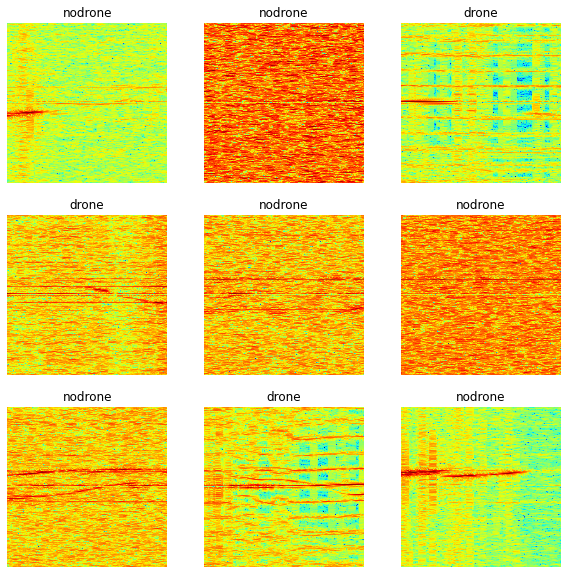

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #print(labels[i])
    #print(labels)
    plt.title(class_names[ int(labels[i]) ])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32, 1)


## Configure data set for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

*Dataset.cache()* keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

*Dataset.prefetch()* overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Transfer learning

# Choosing a pre-trained model
The model we are going to use as the convolutional base for our model is the **Inception V3** developed at Google.

We want to use this model but only its convolutional base. So, when we load in the model, we'll specify that we don't want to load the top (classification) layer. We'll tell the model what input shape to expect and to use the predetermined weights from *imagenet* (Googles dataset).

In [14]:
# Create the base model from the pre-trained model Inception V3
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet'
)

87916544/87910968 [==============================] - 1s 0us/step


In [15]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

At this point this base_model will simply output a shape (32, 3, 3, 2048) tensor that is a feature extraction from our original (1, 160, 160, 3) image. The 32 means that we have 32 layers of differnt filters/features.

In [16]:
for image, _ in train_ds.take(1):
   pass

feature_batch = base_model(image)
print(feature_batch.shape)

(32, 3, 3, 2048)


### Freezing the Base
The term **freezing** refers to disabling the training property of a layer. It simply means we won’t make any changes to the weights of any layers that are frozen during training. This is important as we don't want to change the convolutional base that already has learned weights.

In [17]:
base_model.trainable = False

In [18]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

###Adding our Classifier
Now that we have our base layer setup, we can add the classifier. We will use a global average pooling layer that will average the entire 3x3 area of each 2D feature map and return to us a single 2048 element vector per filter.

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Finally, we will add the predicition layer that will be a single dense neuron. We can do this because we only have two classes to predict for.

In [20]:
prediction_layer = keras.layers.Dense(1)

### Combine the Layers of our Model

In [21]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


### Training our model

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(val_ds, steps = validation_steps)

 1/20 [>.............................] - 0s 44ms/step - loss: 2.8639 - accuracy: 0.5833


In [25]:
# Now we can train it on our images
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

acc = history.history['accuracy']
print(acc)

Epoch 1/10
4/4 [==============================] - 5s 1s/step - loss: 4.6218 - accuracy: 0.3889 - val_loss: 1.5624 - val_accuracy: 0.7917
Epoch 2/10
4/4 [==============================] - 5s 1s/step - loss: 3.2833 - accuracy: 0.5000 - val_loss: 1.3442 - val_accuracy: 0.7083
Epoch 3/10
4/4 [==============================] - 9s 2s/step - loss: 2.9286 - accuracy: 0.4907 - val_loss: 1.2039 - val_accuracy: 0.7083
Epoch 4/10
4/4 [==============================] - 6s 1s/step - loss: 2.6657 - accuracy: 0.4630 - val_loss: 1.0857 - val_accuracy: 0.7500
Epoch 5/10
4/4 [==============================] - 5s 1s/step - loss: 2.4076 - accuracy: 0.4907 - val_loss: 0.9851 - val_accuracy: 0.7083
Epoch 6/10
4/4 [==============================] - 5s 1s/step - loss: 2.1759 - accuracy: 0.5185 - val_loss: 0.9397 - val_accuracy: 0.6667
Epoch 7/10
4/4 [==============================] - 5s 1s/step - loss: 2.0084 - accuracy: 0.5000 - val_loss: 0.8326 - val_accuracy: 0.6667
Epoch 8/10
4/4 [=========================

In [26]:
print(model.metrics_names)

['loss', 'accuracy']


## Visualise the results
Create plots of loss and accuracy on the training and validation sets

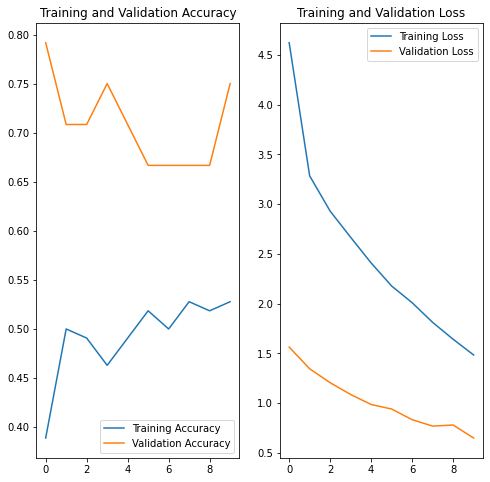

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by some margin and the model has achieved only around 55% accuracy on the validation set

## Overfitting
In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 50% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of **overfitting**

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, we'll use data augmentation and add Dropout to our model

## Experiment 2: Repeat the first experiment, but this time with *data augmentation*, *dropout*, *standardisation* and *fine-tuning*

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using experimental Keras Preprocessing Layers. These can be included inside your model like other layers, and run on the GPU

In [28]:
num_hashing_bins = 200_00
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomContrast((0.1, 0.1), 1),
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=IMG_SHAPE),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2, 0.3),
                                                        width_factor=(-0.2, 0.3),
                                                        fill_mode='reflect',
                                                        interpolation='bilinear',
                                                        seed=1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

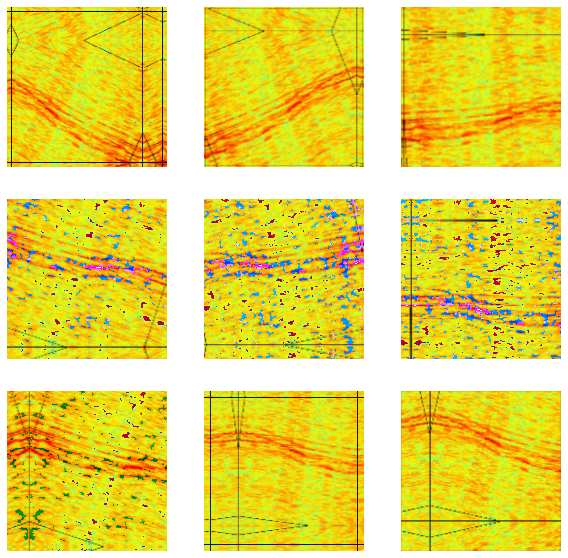

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout
Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images.

## Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer.

In [30]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [31]:
train_dataset = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_dataset))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [32]:
validation_dataset = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(validation_dataset))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [33]:
test_dataset = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(test_dataset))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


##  Fine-tuning
One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

### Un-freeze the top layers of the model
All we need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, we should recompile the model (necessary for these changes to take effect), and resume training.

In [34]:
base_model.trainable = True

In [35]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [36]:
# Fine-tune from this layer onwards
fine_tune_at = 260

In [37]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [38]:
model = tf.keras.Sequential([
  data_augmentation,                           
  base_model,
  global_average_layer,
  layers.Dropout(0.2),
  prediction_layer
])

## Compile and train the model

In [39]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
epochs = 15
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/15
4/4 [==============================] - 8s 2s/step - loss: 0.5510 - accuracy: 0.6759 - val_loss: 0.4140 - val_accuracy: 0.8750
Epoch 2/15
4/4 [==============================] - 6s 2s/step - loss: 0.3900 - accuracy: 0.8426 - val_loss: 0.4853 - val_accuracy: 0.8333
Epoch 3/15
4/4 [==============================] - 8s 2s/step - loss: 0.3196 - accuracy: 0.8241 - val_loss: 0.2482 - val_accuracy: 0.9583
Epoch 4/15
4/4 [==============================] - 6s 2s/step - loss: 0.3161 - accuracy: 0.8889 - val_loss: 0.2125 - val_accuracy: 0.9167
Epoch 5/15
4/4 [==============================] - 6s 2s/step - loss: 0.2819 - accuracy: 0.8519 - val_loss: 0.2012 - val_accuracy: 0.9583
Epoch 6/15
4/4 [==============================] - 6s 2s/step - loss: 0.2392 - accuracy: 0.9167 - val_loss: 0.1391 - val_accuracy: 0.9583
Epoch 7/15
4/4 [==============================] - 6s 2s/step - loss: 0.2176 - accuracy: 0.9167 - val_loss: 0.1283 - val_accuracy: 1.0000
Epoch 8/15
4/4 [=========================

## Visualize training results
After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.

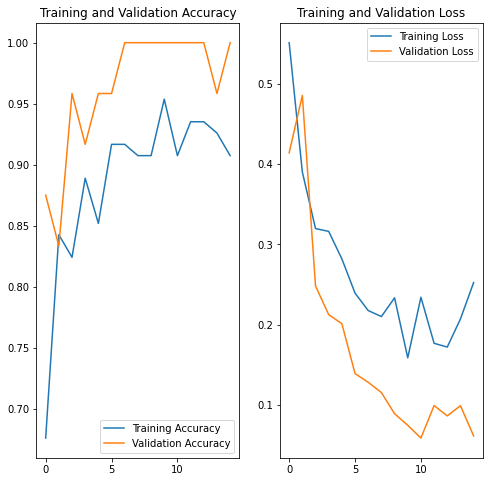

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate the model

In [42]:
for test_data, test_labels in test_dataset:
  print(test_data.shape)
  print(test_labels.shape)
  break

(24, 160, 160, 3)
(24, 1)


In [43]:
test_labels

<tf.Tensor: shape=(24, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>

In [44]:
results = model.evaluate(test_data, test_labels)
print(results)

1/1 [==============================] - 0s 1ms/step - loss: 0.0800 - accuracy: 1.0000
[0.07998637109994888, 1.0]


## Predict on new data
Finally, let's use our model to classify an image that wasn't included in the training or validation sets

In [45]:
predictions = model.predict(test_dataset)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to drone with a 100.00 percent confidence.


In [46]:
predictions

array([[ 4.633909  ],
       [ 3.8474584 ],
       [ 6.4090586 ],
       [11.604786  ],
       [-2.6288874 ],
       [-5.665364  ],
       [ 6.700748  ],
       [ 3.035623  ],
       [ 0.24756771],
       [ 4.608906  ],
       [ 5.5463953 ],
       [ 3.9429107 ],
       [-4.8362007 ],
       [ 8.884786  ],
       [-7.4049034 ],
       [ 2.3714159 ],
       [-0.19039977],
       [-5.732444  ],
       [ 3.3976471 ],
       [-5.0024776 ],
       [ 6.480456  ],
       [ 3.6761453 ],
       [ 4.0047536 ],
       [ 2.0547445 ]], dtype=float32)

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

ypred = list(map(lambda x : 0 if x < 0 else 1, predictions))
ypred = np.array(ypred)
ypred

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1])

In [48]:
def print_score(y_test, y_pred):  
  print("Test Result:\n===========================================")        
  print(f"accuracy score: {accuracy_score(y_test, y_pred)}\n")
  print(f"Classification Report: \n \tPrecision: {precision_score(y_test, y_pred)}\n\tRecall Score: {recall_score(y_test, y_pred)}\n\tF1 score: {f1_score(y_test, y_pred)}\n")

In [49]:
import pandas as pd

In [50]:
def plot_conf_matrix (conf_matrix, dtype):
    class_names = [0,1]
    fontsize=14
    df_conf_matrix = pd.DataFrame(
            conf_matrix, index=class_names, columns=class_names, 
        )
    fig = plt.figure()
    heatmap = sns.heatmap(df_conf_matrix, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for {0}'.format(dtype))


ROC-AUC score: 0.938
Test Result:
accuracy score: 0.9583333333333334

Classification Report: 
 	Precision: 0.9411764705882353
	Recall Score: 1.0
	F1 score: 0.9696969696969697



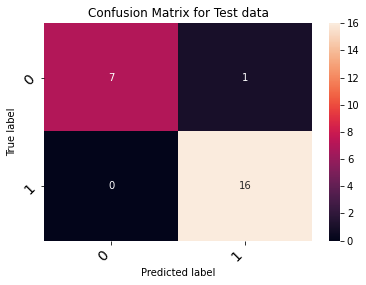

In [51]:
print("\nROC-AUC score: %.3f" % roc_auc_score(test_labels, ypred))
print_score(test_labels, ypred)
plot_conf_matrix(confusion_matrix(test_labels, ypred), "Test data")

In [52]:
# Compute ROC curve and ROC area for each class
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, ypred)

In [53]:
auc_keras = auc(fpr_keras, tpr_keras)

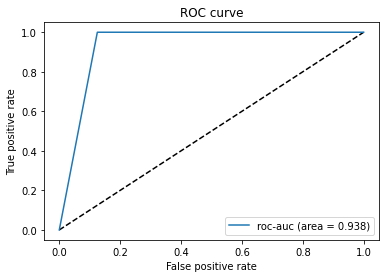

In [54]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='roc-auc (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()